# Bicycle Rental Prediction Project

Using data collected from [Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/), we will be attempting to predict the number of bicycles rented in Washington, DC's city-wide bicycle rental program during any given hour of the day.

[Our dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) contains 17,380 rows, with each row consisting of a single hours data of rental information.  

### Data Dictionary

All columns and a brief description of what each represent:

- instant - A unique sequential ID number for each row

- dteday - The date of the rentals

- season - The season in which the rentals occurred

- yr - The year the rentals occurred

- mnth - The month the rentals occurred

- hr - The hour the rentals occurred

- holiday - Whether or not the day was a holiday

- weekday - The day of the week (as a number, 0 to 7)

- workingday - Whether or not the day was a working day

- weathersit - The weather (as a categorical variable)

- temp - The temperature, on a 0-1 scale

- atemp - The adjusted temperature

- hum - The humidity, on a 0-1 scale

- windspeed - The wind speed, on a 0-1 scale

- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)

- registered - The number of registered riders (people who had already signed up)
    
- cnt - The total number of bike rentals (casual + registered)


The 'casual' column plus the 'registered' column will give us the total amount of renters for each hour.  This makes it a good target column for later analysis.

Let's begin be reading our dataset into pandas and look over the basics of the data:

In [1]:
# importing modules
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# reading dataset into pandas df
df = pd.read_csv('bike_rental_hour.csv', parse_dates=True)

# viewing first rows of data
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
# info on each column 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


### Checking out the correlation between total rental per hour and each other column in our dataset

In order to see what possible features we could use in our prediction algorithm, having a correlation with our target column is a bare minimum threshold to reach. 

In [3]:
# examining correlations between 'cnt' and each column

#creating corr df
corr = df.corr()

# filtering corr df down to just the cnt correlations
corr_cnt = corr['cnt']

# switching values to absolute values for ranking
corr_abs = abs(corr_cnt)

# sorting corrs 
corr_sorted = corr_abs.sort_values()

corr_sorted

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

- It's no surprise that 'registered' and 'casual' are both strongly correlated with cnt, since they both, while summed, make up the 'cnt' column itself.



### Additional Features

One feature that may be nice to use in our predictive algorithms would be a more general time value for when a bike was rented. In addition to keeping track of the hour (between 1-24), we will split our data into more meaningful bins of 'morning, afternoon, evening, and night'.

We will use:
- 1 for morning    (between hours 6 and 12)
- 2 for afternoon  (between hours 12 and 18)
- 3 for evening    (between hours 18 and 24)
- 4 for night      (between hours 0 and 6)


In [4]:
# adding "time_label" feature to df

# defining function to modify hour to 'time_label'
def hour_bin(hour):
    if 0 <= hour < 6:
        return 4
    elif 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    else:
        return 3
    
# assigning time_label to its own column in the df
df['time_label'] = df.hr.apply(hour_bin)

# making sure our new column is present and printing it's unique values to see appx distribution
print(df.time_label.value_counts(dropna=False))
df.head()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In [5]:
# adding the new column to the correlation list

#creating corr df
corr = df.corr()

# filtering corr df down to just the cnt correlations
corr_cnt = corr['cnt']

# switching values to absolute values for ranking
corr_abs = abs(corr_cnt)

# sorting corrs 
corr_sorted = corr_abs.sort_values()

corr_sorted

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
time_label    0.378318
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Checking Data for Missing Values

Since our machine learning algorithms will not run without removing or imputing all missing data, we need to first check our df to see if any missing data is present.

In [6]:
# calculating missing values for each column in df
df.isnull().sum(axis=0)

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
time_label    0
dtype: int64

There is no missing data, so we can proceed to the next step.

## Choosing An Error Metric

Because our target column 'cnt' is linear and we would like use values that are easy to explain ("we were off by 20 bicycles"), we will be using the mean absolute error, or MAE as our way of measuring how far off we are from a perfect prediction.

In [7]:
# importing mean_squared_error, so we can simply use the square root of that as MAE
from sklearn.metrics import mean_absolute_error

## Creating Test/Train Split

In order to test our prediction on never-before-seen data, we will need separate data to 'train' our algorithm, and another set to test our predictions against actual values.

In [8]:
# creating train/test data sets

# separating features from target data

target = df['cnt']
features = df.drop(['cnt', 'casual', 'registered'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=42) 

print('Length of X_train: ', "{}{}".format(len(X_train), ' values'))

print('Length of X_test: ', "{}{}".format(len(X_test), ' values'))

print('Length of y_train: ', "{}{}".format(len(y_train), ' values'))

print('Length of y_test: ', "{}{}".format(len(y_test), ' values'))

Length of X_train:  13903 values
Length of X_test:  3476 values
Length of y_train:  13903 values
Length of y_test:  3476 values


## Choosing Machine Learning Algorithm

Since our target column is linear, and most columns in the feature set appear to have a linear relationship with the target variable, Linear Regression should be an appropriate choice for making accurate predictions.

When choosing our features, we don't want to include any columns that would "leak" data about the final 'cnt' column.  Remember from earlier than the 'cnt' column was made up of the addition of two other columns.  We will need to drop those from the test and train column.

We will write a function definition to choose our functions based on the minimum correlation between each column in the feature-set and it's correlation to 'cnt'.

In [9]:
# editing the removed columns from out corr_sorted list
corr_sorted = corr_sorted[:-3]

In [10]:
# list of possible correlation minimums
corr_mins = np.linspace(0,.4,10)

# function to create list of features
def feature_select(df, corr):
    
    # list of features over minimum correlation 
    feat_list = []
    
    # looping through each correlated col_name
    for col_name in corr_sorted.index:        
        # if the column is correlated less than "corr" append the column name to our list
        if corr_sorted[col_name] >= corr:
            feat_list.append(col_name)
    
    # return all columns from df that are in our list (high corr value columns)
    return df[feat_list]
        


Now we will:

- set minimum correlation between feature column and target column as our hyper-parameter to optimize


- loop over our list of possible minimum correlation values


- for each loop, train a linear regression on our train set


- test our algorithm on our test set


- use kfold cross-validation to see the MAE (error value) of our results


- compile all the corr_min values with MAE values, and find the most accurate one

In [11]:
# importing cross_validation
from sklearn.model_selection import cross_val_score

# list to keep track of accuracy for each corr_min value
score_list = []

# looping through all correlation values
for corr_m in corr_mins:
    # using a single df for features and single df for target for use with cross_val score
    feature_set = feature_select(df, corr=corr_m)
    target = df.cnt
#     print(corr_n)
#     print(feature_set.head())
#     print(target.head())
#     print('\n','\n')
    
    # create LinRegression obj 
    lr = LinearRegression()
    # use cross_val_score to give mean absolute errer
    AEs = cross_val_score(lr, feature_set, target, cv=10, scoring='neg_mean_absolute_error', n_jobs=8)
    MAE = abs(np.mean(AEs))
    score_list.append(MAE)

score_list

[102.52703918626162,
 102.36589297915472,
 102.36589297915472,
 102.33134969265542,
 102.34933353501276,
 102.72195969137161,
 102.39998562131157,
 106.60679417440801,
 110.14961615550956,
 128.31115838823172]

Now that we have our RMSE values for each minimum correlation value, let's graph them.



<IPython.core.display.Javascript object>


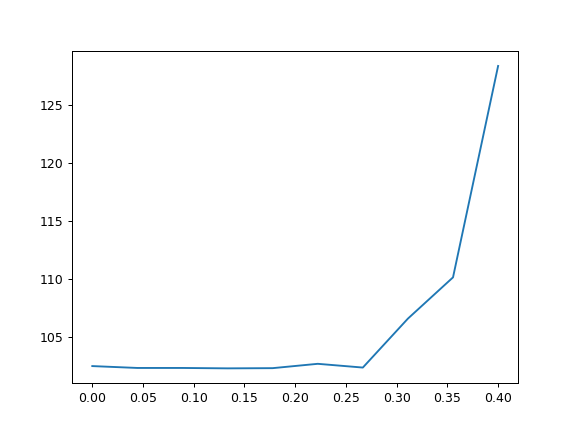

In [12]:
# jupyter magic to show plots inline
%matplotlib notebook

sns.lineplot(x=corr_mins, y=score_list)
plt.show()

In [27]:
# since it looks pretty close with low correlation minimums, we will calculate the exact best correlation minimum values

# finding the index value on the minimum error in score_list
min_index = score_list.index(min(score_list))

# finding the corresponding corr value in the corr_mins list
best_corr = corr_mins[min_index]

print('The best minimum correlation value is {:2f}'.format(best_corr))
print('The lowest error achieved was {} {}'.format(round(min(score_list),2), 'bicycles per day'))


The best minimum correlation value is 0.133333
The lowest error achieved was 102.33 bicycles per day


We can clearly see that by using more features in our feature set, we were able to minimize our error.

To quantify how good/bad the error was, let's look into how many bikes a day are rented on average to see how close we are relatively speaking.

In [14]:
df.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

So the mean amount of Bikes rented was 189, but the std is very high at 181.  Our predictor was more accurate than the standard deviation, but not by much.  Next, we will try a different algorithm to see if we can improve our accuracy.

## Creating An Alternative Model Using A Decision Tree

Suspecting that our Linear Regression may have under-fit the training set, we will now try to build a decision tree to up our accuracy.  Decision trees are notorious for over-fitting the training data, but we can optimize the algorithm later to attempt to fix some of the over-fitting.

Since our target column is linear data, we will need to import 'Decision Tree Regressor' as opposed to 'Decision Tree Classifier'.



In [15]:
# imporint decision tree module
from sklearn.tree import DecisionTreeRegressor

# creating the tree
clf = DecisionTreeRegressor(random_state=42)

# feature and target
feature_set = feature_select(df, corr=0)
target = df.cnt

# k-fold cross_validation to calc mean absolute errors in each fold
AEs = cross_val_score(clf, feature_set, target, cv=10, scoring='neg_mean_absolute_error', n_jobs=8)

# calculating the mean of all folds
MAE = abs(AEs.mean())

print('The error achieved was {} {}'.format(round(MAE,2), 'bicycles per day'))

The error achieved was 51.03 bicycles per day


So our basic decision tree scored much more accurately than our Linear Regression did, but are many things we can do to optimize our tree to perform *even* better.  To check for over-fitting of data, let's see how our decision tree predicts values in a training data set.

for this, we will need to use our test/train splits from earlier, and not use the cross_val_score function.

In [16]:
# Making sure X_train only contain the same columns as our previous prediction
X_train = feature_select(X_train, corr=0)
X_test = feature_select(X_test, corr=0)


# creating the tree
clf = DecisionTreeRegressor(random_state=42)

# creating our tree by training on test data
clf.fit(X_train, y_train)

# checking our performance on test set first
test_predict = clf.predict(X_test)
# calculating the absolute difference of each row
test_diff = abs(test_predict - y_test)
# calculating mean absolute error
MAE_test = test_diff.mean()


# checking our performance on train set next
train_predict = clf.predict(X_train)
# calculating the absolute difference of each row
train_diff = abs(train_predict - y_train)
# calculating mean absolute error
MAE_train = train_diff.mean()

print("Train MAE: ", round(MAE_train, 2))
print("Test MAE: ", round(MAE_test, 2))


Train MAE:  0.0
Test MAE:  33.49


This error rate was even lower for the test data, but that could simply be noise due to the lack of performing k-fold cross validation.  The important thing to notice is the *lack of any error rate at all* for the training set.

This is a nearly sure sign that our tree is over-fitting the data.  There are many things we can due to fix this, but one is to perform Cost Complexity Pruning on our tree.

## Cost Complexity Pruning of Our Decision Tree

While there are many hyperparameters that can be tuned within any given tree, we will only experiment with a couple to increase our accuracy.

We will be using:

- max_depth (the depth of levels the tree is allowed to reach to create a leaf)

- min_samples_leaf (the minimum amount of rows left that will create a leaf node)


## min_samples_leaf

<IPython.core.display.Javascript object>


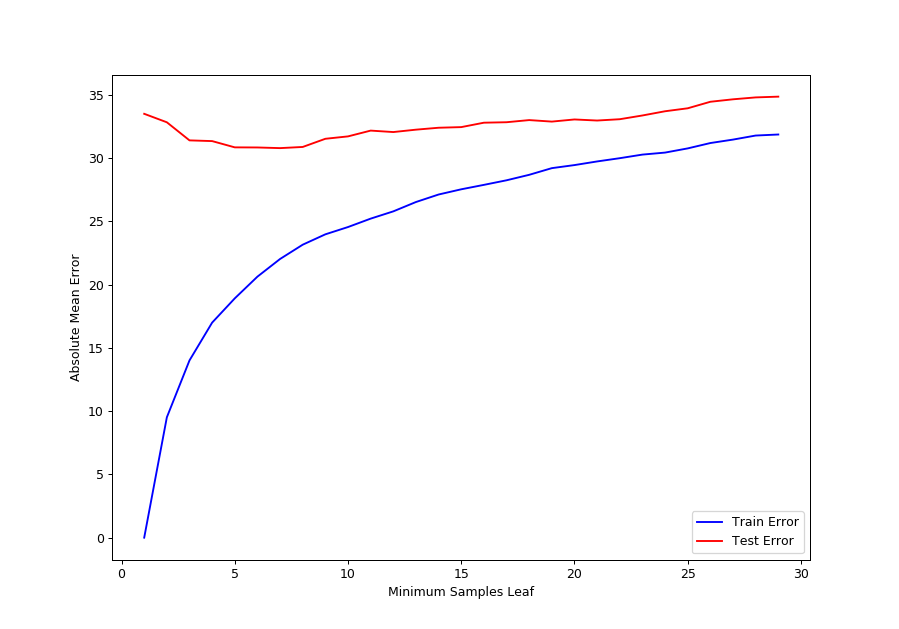

In [17]:
# playing with the min_samples_leaf hyperparameter
msls = np.arange(1,30,1)

# creating list to hold trees with each min_samples_leaf
tree_list = []

# looping through list of min_samples_leaf, creating a tree for each
for msl in msls:
    clf_md = DecisionTreeRegressor(random_state=42, min_samples_leaf=msl)
    clf_md.fit(X_train, y_train)
    tree_list.append(clf_md)
    
    
# creating a list of training accuracy scores and testing accuracy scores using a list comprehension

test_scores = []    #to hold test accuracy scores of prediction
train_scores = []  # to hold train accuracy scores of prediction

for tree in tree_list:
    train_predict = tree.predict(X_train)
    train_MAE = np.mean(abs(train_predict - y_train))
    train_scores.append(train_MAE)
    
    test_predict = tree.predict(X_test)
    test_MAE = np.mean(abs(test_predict - y_test))
    test_scores.append(test_MAE)



# graphing the train scores against the test scores to find approximate best value for max_depth
fig = plt.figure(figsize=(10,7))
plt.plot(msls,train_scores, c='blue', label='Train Error')
plt.plot(msls, test_scores, c='red', label='Test Error')
plt.legend()
plt.xlabel('Minimum Samples Leaf')
plt.ylabel('Absolute Mean Error')
plt.show()




Looking at our graph, we can see that using a Minimum Samples Leaf of around six minimized error on the test data, despite increasing the error on the training data.  This is to be expected, since correcting over-fitting will necessarily increase error on the training set.  Let's see if our tree is more accurate than before, using a Minimum Samples Leaf of 6.

Our former error was 51.03 Bicycles per day.

In [18]:
# creating the tree
clf = DecisionTreeRegressor(random_state=42, min_samples_leaf=6)

# feature and target
feature_set = feature_select(df, corr=0)
target = df.cnt

# k-fold cross_validation to calc mean absolute errors in each fold
AEs = cross_val_score(clf, feature_set, target, cv=10, scoring='neg_mean_absolute_error', n_jobs=8)

# calculating the mean of all folds
MAE = abs(AEs.mean())

print('The error achieved was {} {}'.format(round(MAE,2), 'bicycles per day'))

The error achieved was 47.2 bicycles per day


## max_depth

Hooray, we were able to improve our accuracy by around six percent by optimizing a single hyperparameter.  Next, we will use the same method we used on min_samples_leaf with the max_depth hyperparameter.

<IPython.core.display.Javascript object>


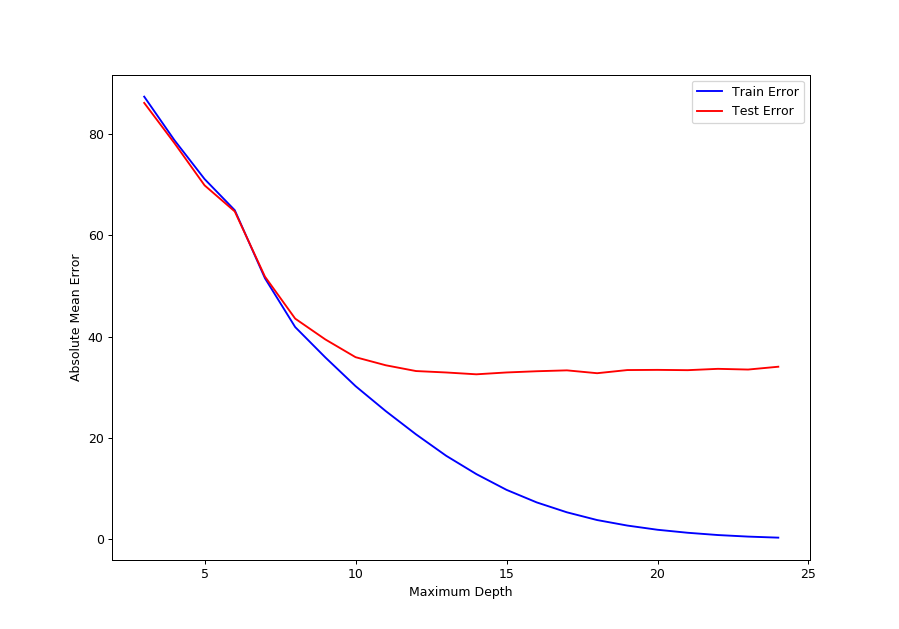

In [19]:
# playing with the max_depth hyperparameter
mds = np.arange(3,25,1)

# creating list to hold trees with each max_depth
tree_list = []

# looping through list of max_depth, creating a tree for each
for md in mds:
    clf_md = DecisionTreeRegressor(random_state=42, max_depth=md)
    clf_md.fit(X_train, y_train)
    tree_list.append(clf_md)
    
    
# creating a list of training accuracy scores and testing accuracy scores using a list comprehension

test_scores = []    #to hold test accuracy scores of prediction
train_scores = []  # to hold train accuracy scores of prediction

for tree in tree_list:
    train_predict = tree.predict(X_train)
    train_MAE = np.mean(abs(train_predict - y_train))
    train_scores.append(train_MAE)
    
    test_predict = tree.predict(X_test)
    test_MAE = np.mean(abs(test_predict - y_test))
    test_scores.append(test_MAE)


# graphing the train scores against the test scores to find approximate best value for max_depth
fig = plt.figure(figsize=(10,7))
plt.plot(mds,train_scores, c='blue', label='Train Error')
plt.plot(mds, test_scores, c='red', label='Test Error')
plt.legend()
plt.xlabel('Maximum Depth')
plt.ylabel('Absolute Mean Error')
plt.show()


It's much harder to eye ball where the lowest error for the test data (red line) on the chart fell.  We will calculate it by hand.

In [20]:
# index of test_scores with lowest error
index = test_scores.index(min(test_scores))

# indexing mds with 'index'
mds[index]

14

Now we will plug back 14 into our original decision tree code and see if it outperformed our original error of 51.03 bicycles per day.

# creating the tree
clf = DecisionTreeRegressor(random_state=42, max_depth=14)

# feature and target
feature_set = feature_select(df, corr=0)
target = df.cnt

# k-fold cross_validation to calc mean absolute errors in each fold
AEs = cross_val_score(clf, feature_set, target, cv=10, scoring='neg_mean_absolute_error')

# calculating the mean of all folds
MAE = abs(AEs.mean())

print('The error achieved was {} {}'.format(round(MAE,2), 'bicycles per day'))

Not much improvement by using the max_depth hyperparameter, but let's see if we improve accuracy over using min_samples_leaf alone (47.2 bicycles per day).

In [29]:
# creating the tree
clf = DecisionTreeRegressor(random_state=42, max_depth=14, min_samples_leaf=6)

# feature and target
feature_set = feature_select(df, corr=0)
target = df.cnt

# k-fold cross_validation to calc mean absolute errors in each fold
AEs = cross_val_score(clf, feature_set, target, cv=10, scoring='neg_mean_absolute_error', n_jobs=8)

# calculating the mean of all folds
MAE = abs(AEs.mean())

print('The error achieved was {} {}'.format(round(MAE,2), 'bicycles per day'))

The error achieved was 46.86 bicycles per day


## Conlcusion

So by combining our optimized hyper-parameters, we were able to achieve a better, more accurate result than using each one by themselves.

## Random Forest Regression

Another algorithm we can run is the Random Forest Regressor.

Random Forest Regressor combines random feature selection with 'bagging'.  Bagging is essentially taking a random sample of the tree many times (with replacement) and experimenting with different feature selection on each 'bag'.  Another word for this is an 'ensemble,' of different algorithms.

This makes Random Forest Regressor very computationally difficult, but more accurate than a simple Decision Tree Regressor, at the expense of computational power, or time.

Let's see how Random Forest stacks up against our simple hyperparameter-optimized Regression Tree.

\* We are also setting the n_jobs parameter equal to 8, to take advantage of our 8-core processor.  If your machine does not support this setting, please delete and use the default parameter.

In [28]:
# importing random forest regressor
from sklearn.ensemble import RandomForestRegressor

# creating random forest object with hyperparameters from earlier experiments
rf = RandomForestRegressor(random_state=42, max_depth=14, min_samples_leaf=6, n_estimators=150, n_jobs=8)

# feature and target
feature_set = feature_select(df, corr=0)
target = df.cnt

# k-fold cross_validation to calc mean absolute errors in each fold
AEs = cross_val_score(rf, feature_set, target, cv=10, scoring='neg_mean_absolute_error')

# calculating the mean of all folds
MAE = abs(AEs.mean())

print('The error achieved was {} {}'.format(round(MAE,2), 'bicycles per day'))

The error achieved was 40.3 bicycles per day


## Conclusion

While it took much more time to calculate, the error was far lower than using decision tree hyperparameter optimization alone.

As a small experiment, let's compare the results of a Random Forest without any of our previous hyperparameter optimization to the earlier optimized decision tree.

In [23]:
# running the same random forest but without the hyperparamters from earlier to see if it mattered much with
# regard to accuracy

# creating random forest object with hyperparameters from earlier experiments
rf = RandomForestRegressor(random_state=42, n_estimators=150, n_jobs=8)

# feature and target
feature_set = feature_select(df, corr=0)
target = df.cnt

# k-fold cross_validation to calc mean absolute errors in each fold
AEs = cross_val_score(rf, feature_set, target, cv=10, scoring='neg_mean_absolute_error')

# calculating the mean of all folds
MAE = abs(AEs.mean())

print('The error achieved was {} {}'.format(round(MAE,2), 'bicycles per day'))

The error achieved was 39.72 bicycles per day


## Conclusion

Interestingly enough, carrying over the hyperparameter optimization from our basic decision tree into the random forest regressor actually *lowered* our accuracy.  It must interfere with the "smarter" optimization that is happening within the random forest algorithm.

If we were going to experiment with hyperparameter optimization within our random forest regressor, it seems as though we will not be able to perform it on the faster, more basic decision tree and attempt to "carry it over" to our random forest.